### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as web
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from datetime import datetime as dt
from pandas.plotting import lag_plot

# from mpl_finance import candlestick_ohlc

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

plt.style.use('fivethirtyeight')

Importing plotly failed. Interactive plots will not work.


### Hypothesis & Goals of the Notebook

Was the important spike of the stock price from mid-2019 onwards predictible ?
What are potential predictions of the future stock price ?

- Tesla stock price evolution has grown constantly on a 1.5% basis from 2010 to 2018, up to 7% from mid-2019 onwards.
How will this difference plot out in the prediction ?

- Using Facebook developed tool Prophet in order to model stock prediction in a 2-3 year period
Will Prophet be able to get realistic predictions ?

Facebook Prophet has been chosen for its easy usage and its recommendations by professionals to predict long-term trends.

## Importing Tesla daily stock exchange values from 2010 IPO onwards

Measuring & comparing average growth from 2010 to 2019 & from 2019 onwards

Creating 2 different dataframes to measure it

In [169]:
df_TSLA = pd.read_csv('../DataSets/Stocks_raw_data/TSLA_stocks_rate_2010-01-01_to_2020-03-08.csv')

##### DataWrangling

Adding PCT indicator & reseting index to be divide dataframe on Dates

In [170]:
df_TSLA['PCT_change'] = df_TSLA['Adj Close'].pct_change(fill_method='ffill')

In [171]:
df_TSLA.reset_index(drop=False , inplace=True)
df_TSLA['Date'] = pd.to_datetime(df_TSLA['Date'])
# df_TSLA.set_index('Date', inplace=True)

In [172]:
df_TSLA.describe()

,index,High,Low,Open,Close,Volume,Adj Close,avg_price,PCT_change
count,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2.439000e+03,2439.000000,2439.000000,2438.000000
mean,1219.000000,195.485543,188.333460,191.944125,192.041558,5.729509e+06,192.041558,191.909502,0.001936
std,704.222976,134.876723,129.066800,131.914886,132.077043,5.349071e+06,132.077043,131.938077,0.033244
min,0.000000,16.629999,14.980000,16.139999,15.800000,1.185000e+05,15.800000,15.804999,-0.193274
25%,609.500000,35.000000,33.805000,34.500000,34.455000,1.948650e+06,34.455000,34.355000,-0.014345
50%,1219.000000,217.929993,209.809998,214.190002,214.360001,4.625700e+06,214.360001,213.495003,0.000864
75%,1828.500000,273.949997,265.434998,269.740005,269.215012,7.465700e+06,269.215012,269.334999,0.018129
max,2438.000000,968.989990,901.020020,923.500000,917.419983,6.093880e+07,917.419983,922.900024,0.243951


In [178]:
df_TSLA_2010_2019 = df_TSLA[df_TSLA.Date < '2019-06-01']

In [179]:
df_TSLA_2010_2019.describe()

,index,High,Low,Open,Close,Volume,Adj Close,avg_price,PCT_change
count,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2.246000e+03,2246.000000,2246.000000,2245.000000
mean,1122.500000,180.444403,174.093139,177.370022,177.355922,5.223830e+06,177.355922,177.268771,0.001437
std,648.508674,116.598688,112.918082,114.829989,114.828533,4.663578e+06,114.828533,114.743684,0.032541
min,0.000000,16.629999,14.980000,16.139999,15.800000,1.185000e+05,15.800000,15.804999,-0.193274
25%,561.250000,34.174998,32.854999,33.449999,33.544999,1.651150e+06,33.544999,33.462500,-0.014893
50%,1122.500000,209.850006,203.000000,206.629997,206.680000,4.270650e+06,206.680000,206.837502,0.000460
75%,1683.750000,266.529991,258.459999,262.474991,262.539993,7.019075e+06,262.539993,262.062504,0.017704
max,2245.000000,389.609985,379.350006,386.690002,385.000000,3.716390e+07,385.000000,383.644989,0.243951


In [180]:
df_TSLA_2019_2020 = df_TSLA[df_TSLA.Date > '2019-06-01']

In [181]:
df_TSLA_2019_2020.describe()

,index,High,Low,Open,Close,Volume,Adj Close,avg_price,PCT_change
count,193.000000,193.000000,193.000000,193.000000,193.000000,1.930000e+02,193.000000,193.000000,193.000000
mean,2342.000000,370.523886,354.052436,361.547410,362.942798,1.161425e+07,362.942798,362.288161,0.007735
std,55.858452,196.436385,180.164189,188.107132,188.279958,8.438821e+06,188.279958,188.164575,0.040188
min,2246.000000,186.679993,176.990005,181.100006,178.970001,2.465600e+06,178.970001,181.834999,-0.171758
25%,2294.000000,234.740005,227.279999,230.800003,231.429993,6.190800e+06,231.429993,230.985001,-0.007041
50%,2342.000000,262.100006,254.619995,258.329987,258.179993,8.787000e+06,258.179993,258.169998,0.005977
75%,2390.000000,425.470001,410.000000,418.359985,419.220001,1.412100e+07,419.220001,419.080002,0.020907
max,2438.000000,968.989990,901.020020,923.500000,917.419983,6.093880e+07,917.419983,922.900024,0.198949


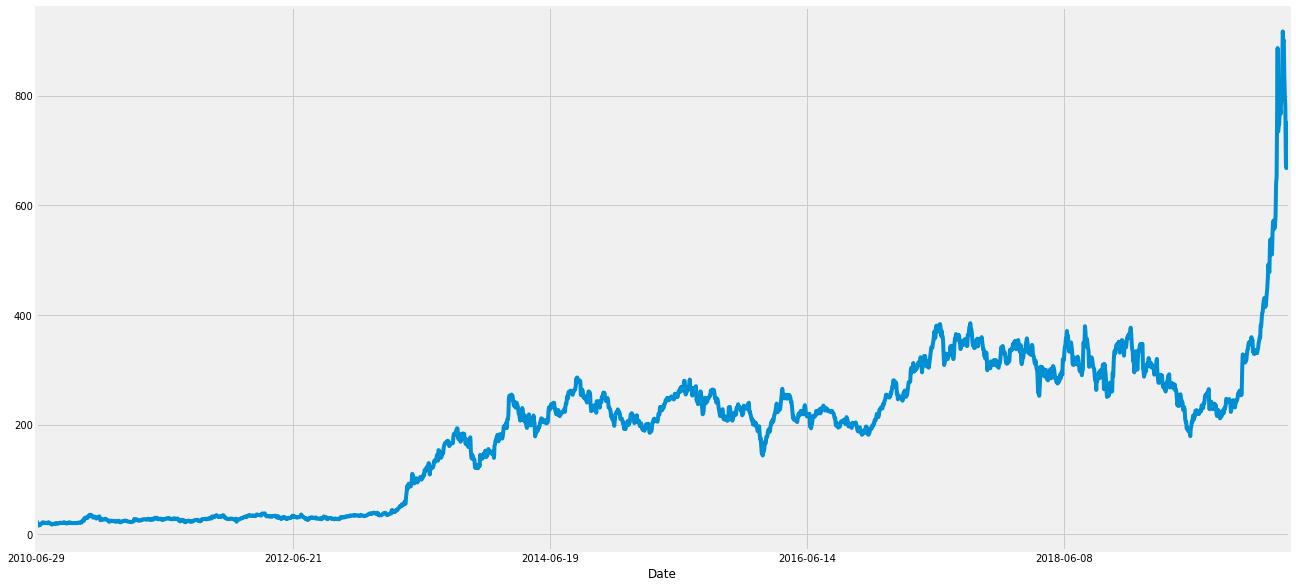

In [156]:
df_TSLA['Adj Close'].plot(figsize=(20,10))

# Part 1 - Analyzing past tendencies

# Measuring Tesla stock volatility from 2010 onwards

### Rolling Tesla Values

Creating Rolling values over several classical financal timeframe analysis :
- 7-day rolling
- 50-day rolling
- 100-day rolling
- 200-day rolling

Those 4 classic day rolling periods aim at smoothen daily volatility in order to evaluate long-time trends

In [16]:
df_TSLA['7D_roll'] = df_TSLA['Adj Close'].rolling(7).mean()

df_TSLA['50D_roll'] = df_TSLA['Adj Close'].rolling(50).mean()

df_TSLA['100D_roll'] = df_TSLA['Adj Close'].rolling(100).mean()

df_TSLA['200D_roll'] = df_TSLA['Adj Close'].rolling(200).mean()

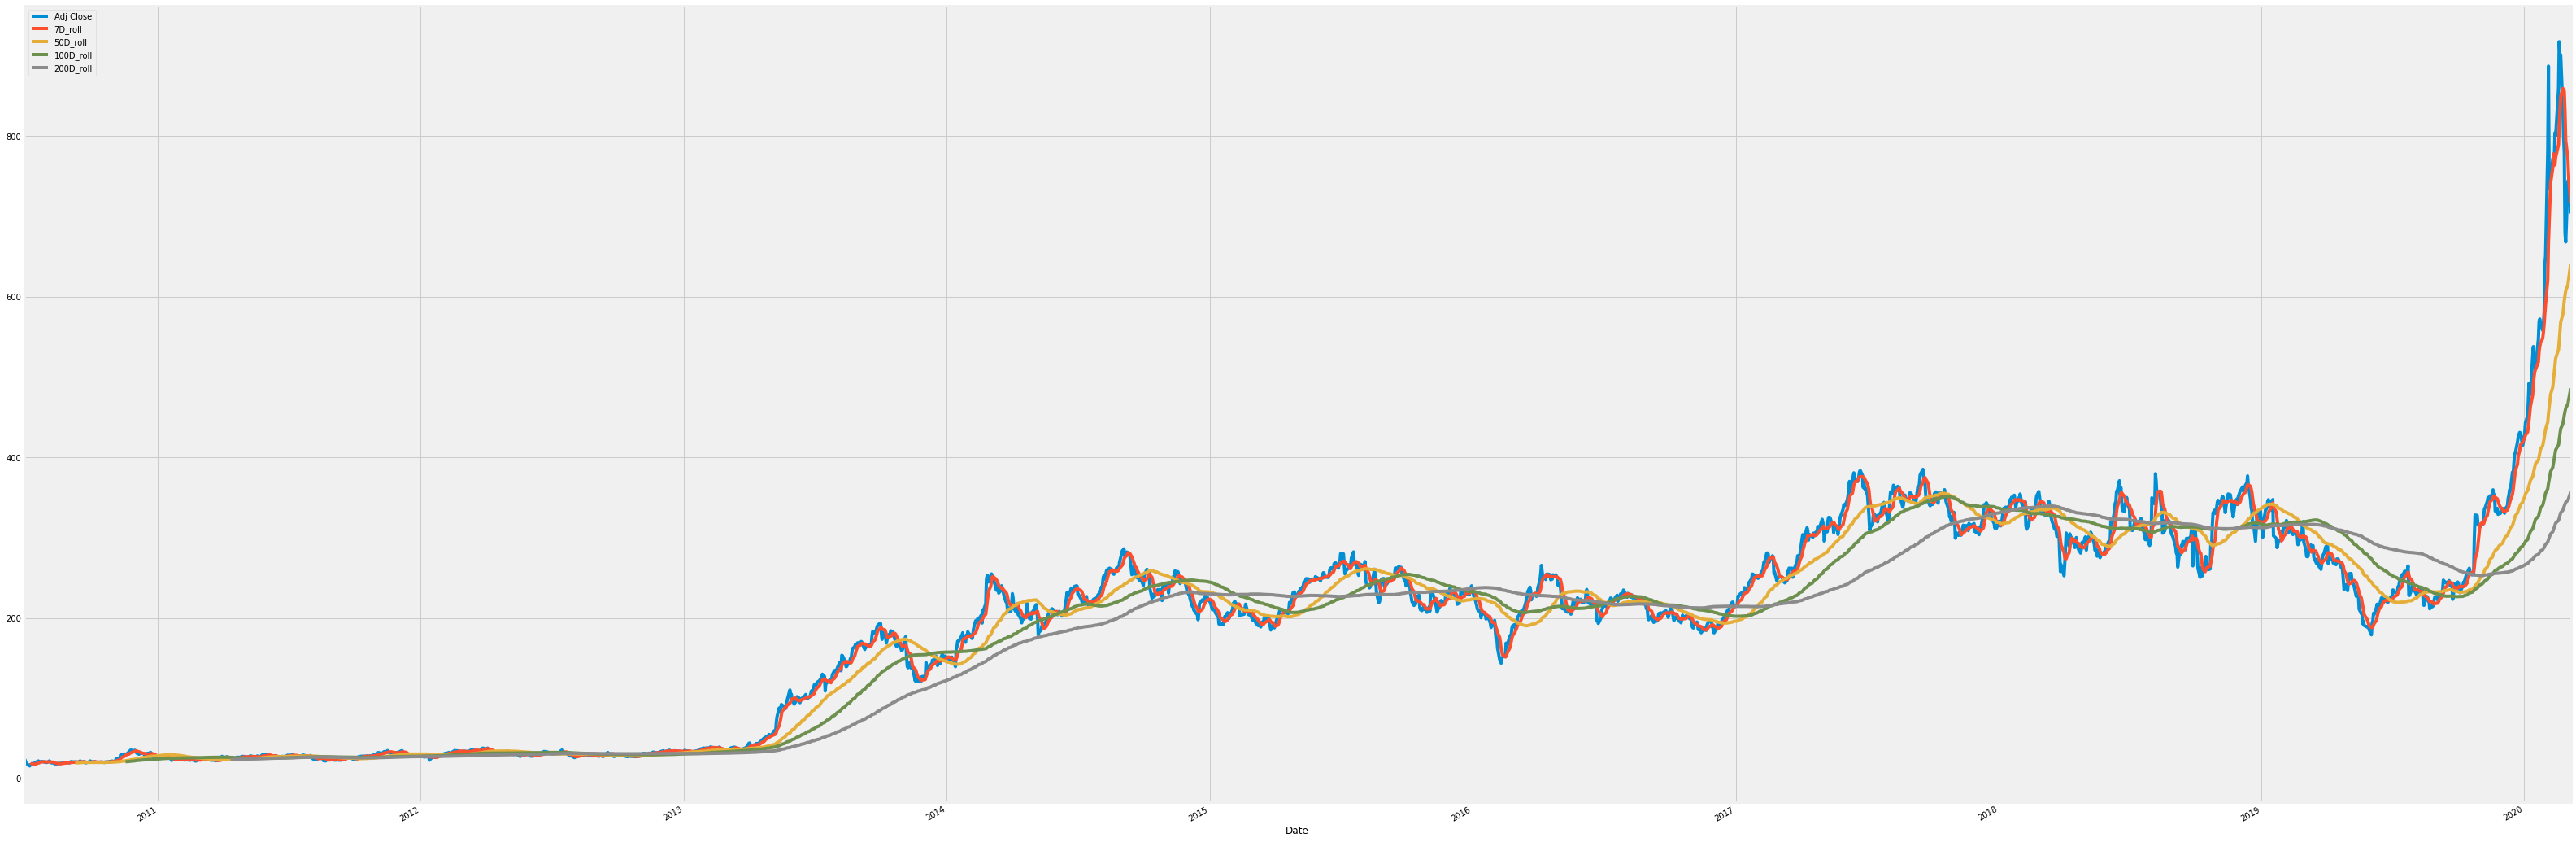

In [17]:
df_TSLA[['Adj Close', '7D_roll', '50D_roll', '100D_roll', '200D_roll']].plot(figsize=(50,20))

The higher the roll, the less the trend is influenced by daily volatility and the overall trend can be drawn

# Part 2 - Stock Prediction through Prophet

### 2 - 1 Testing out Prophet over 2019 based on pre-2018 data

###### Splitting dataframe into a train set (up to March 2018) & a test set (from March 2018 onwards)

In [87]:
df_TSLA_train_2018, df_TSLA_test_2018 = df_TSLA_pred[0:int(len(df_TSLA_pred)*0.75)], df_TSLA_pred[int(len(df_TSLA_pred)*0.25):]

In [88]:
df_TSLA_train_2018.columns = ['ds', 'y']

In [89]:
df_TSLA_test_2018.columns = ['ds', 'y']

In [90]:
df_TSLA_train_2018

,ds,y
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001
5,2010-07-07,15.800000
6,2010-07-08,17.459999
7,2010-07-09,17.400000
8,2010-07-12,17.049999
9,2010-07-13,18.139999


Setting out a Prophet instance to measure prediction over a 2.5 year period , i.e 910 days, in order to compare it to actual data

In [103]:
proph_2018 = Prophet(interval_width=0.95)

In [104]:
proph_2018.fit(df_TSLA_train_2018)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [105]:
future_data_2018  = proph_2018.make_future_dataframe(periods=910, freq = 'd')

In [106]:
forecast_2018 = proph_2018.predict(future_data_2018)

In [126]:
tsla_forecast_2018 = forecast_2018[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [123]:
# tsla_forecast_2018.rename(columns={'ds':'date', 'yhat':'Adj_Close'}, inplace=True)

C:\Users\langl\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


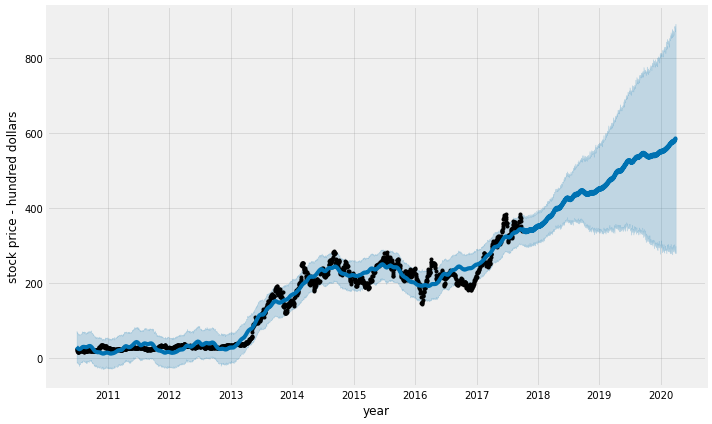

In [141]:
proph_2018.plot(tsla_forecast_2018, uncertainty=True, xlabel='year',ylabel='stock price - hundred dollars')
plt.savefig('../DataSets/Stock_prediction_PNG/Prophet_stock_prediction_2018-2020.png')

Evaluating tipping points in the Stock evolution

[[<matplotlib.lines.Line2D at 0x21dcfa142b0>],

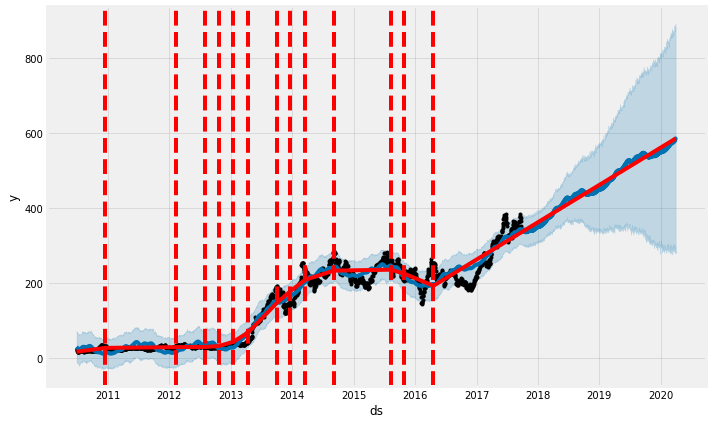

In [127]:
fig_2018 = proph_2018.plot(forecast_2018)
add_changepoints_to_plot(fig_2018.gca(), proph_2018, forecast_2018)

### Testing Seasonal Decomposition

- No strong seasonality in the stock price evolution, trend overall constantly growing, with no particular seasonal peak
- Highest evolution year over year during Autumn & Winter seasons

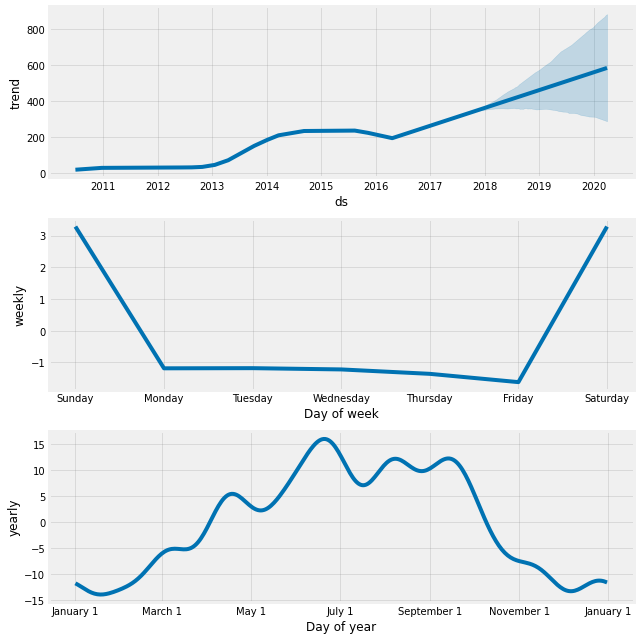

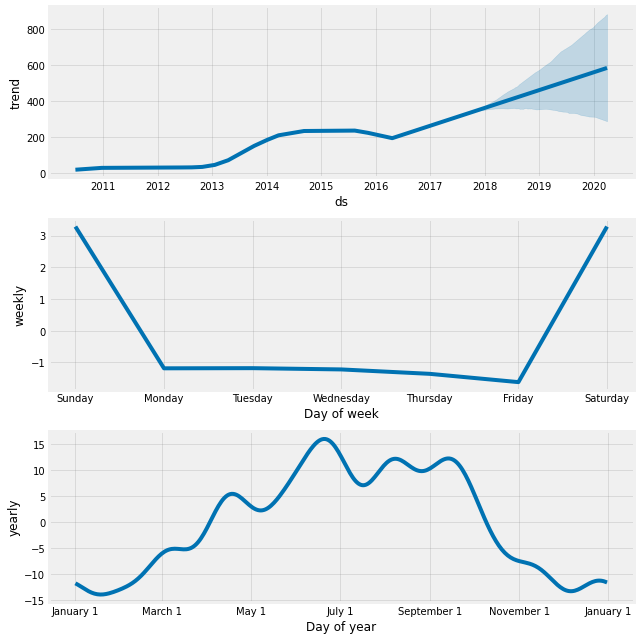

In [139]:
proph_2018.plot_components(forecast_2018)

In [20]:
df_TSLA.set_index('Date', inplace=True)

In [65]:
df_TSLA

,High,Low,Open,Close,Volume,Adj Close,avg_price
Date,,,,,,,
2010-06-29,25.000000,17.540001,19.000000,23.889999,18766300.0,23.889999,21.270000
2010-06-30,30.420000,23.299999,25.790001,23.830000,17187100.0,23.830000,26.860000
2010-07-01,25.920000,20.270000,25.000000,21.959999,8218800.0,21.959999,23.095000
2010-07-02,23.100000,18.709999,23.000000,19.200001,5139800.0,19.200001,20.905000
2010-07-06,20.000000,15.830000,20.000000,16.110001,6866900.0,16.110001,17.915000
2010-07-07,16.629999,14.980000,16.400000,15.800000,6921700.0,15.800000,15.804999
2010-07-08,17.520000,15.570000,16.139999,17.459999,7711400.0,17.459999,16.545000
2010-07-09,17.900000,16.549999,17.580000,17.400000,4050600.0,17.400000,17.224999
2010-07-12,18.070000,17.000000,17.950001,17.049999,2202500.0,17.049999,17.535000


In [11]:
proph = Prophet()

In [23]:
df_TSLA_pred =  df_TSLA['Adj Close'].reset_index()

In [24]:
df_TSLA_pred

,Date,Adj Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001
5,2010-07-07,15.800000
6,2010-07-08,17.459999
7,2010-07-09,17.400000
8,2010-07-12,17.049999
9,2010-07-13,18.139999


In [25]:
df_TSLA_pred.columns = ['ds', 'y']

In [26]:
df_TSLA_pred

,ds,y
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001
5,2010-07-07,15.800000
6,2010-07-08,17.459999
7,2010-07-09,17.400000
8,2010-07-12,17.049999
9,2010-07-13,18.139999


In [66]:
proph.fit(df_TSLA_pred)

Exception: Prophet object can only be fit once. Instantiate a new object.

In [74]:
future_data  = proph.make_future_dataframe(periods=365*2, freq = 'd')

In [75]:
forecast = proph.predict(future_data)

In [76]:
# forecast

In [77]:
tsla_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

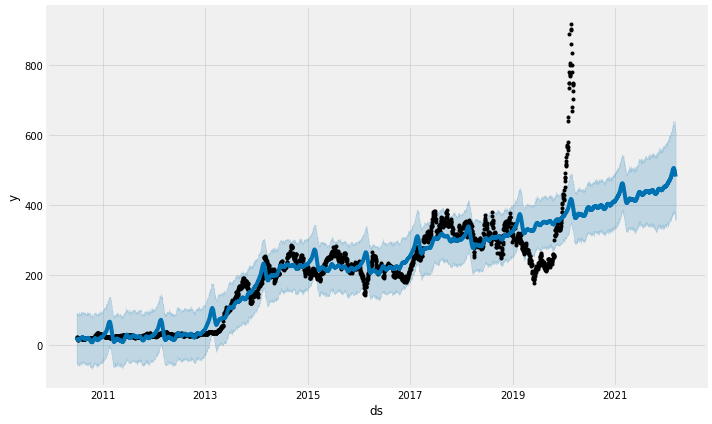

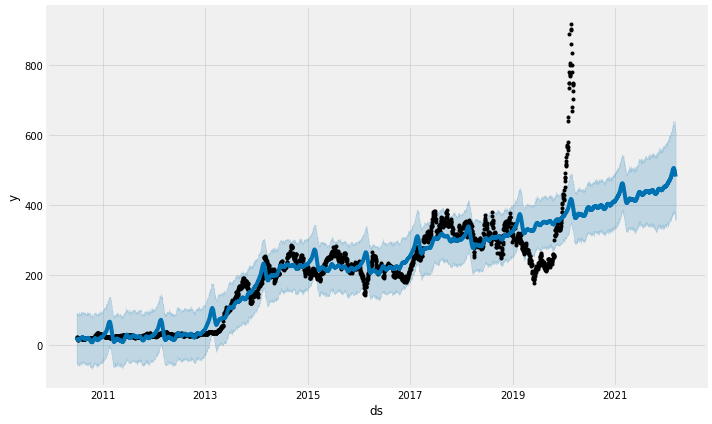

In [78]:
proph.plot(tsla_forecast)

#### Test Prophet 2

In [28]:
df_TSLA_pred =  df_TSLA['Adj Close'].reset_index()

# Setting out trend from the overall real data

In [52]:
df_TSLA_pred = df_TSLA['Adj Close'].reset_index(drop=False)

In [53]:
df_TSLA_adj_close_dateless

,Date,Adj Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001
5,2010-07-07,15.800000
6,2010-07-08,17.459999
7,2010-07-09,17.400000
8,2010-07-12,17.049999
9,2010-07-13,18.139999


In [54]:
# df_TSLA_dateless.reset_index(drop=True, inplace=True)

In [55]:
MinMaxScaler = preprocessing.MinMaxScaler(feature_range=(0,1))

In [56]:
#feeding the original DF Tesla with 
df_TSLA['y'] = MinMaxScaler.fit_transform(df_TSLA_adj_close_dateless)

ValueError: could not convert string to float: '2010-06-29'

In [57]:
df_TSLA_prophet = df_TSLA['y'].reset_index(drop=False)

KeyError: 'y'

In [58]:
df_TSLA_prophet

NameError: name 'df_TSLA_prophet' is not defined

In [59]:
# #creating a Prophet value
df_TSLA_adj_close_dateless.columns = ['ds','y']

In [60]:
# df_TSLA_train_2018_minmax, df_TSLA_test_2018_minmax = df_TSLA_adj_close_dateless[0:int(len(df_TSLA_adj_close_dateless)*0.75)], df_TSLA_adj_close_dateless[int(len(df_TSLA_adj_close_dateless)*0.25):]

In [61]:
# df_TSLA_train_2018_minmax, df_TSLA_test_2018_minmax = df_TSLA_prophet[0:int(len(df_TSLA_prophet)*0.75)], df_TSLA_prophet[int(len(df_TSLA_prophet)*0.25):]

In [62]:
#df_TSLA_train_2018_minmax.columns = ['ds','y']

In [377]:
# df_TSLA_train_2018_minmax.dtypes

# Setting out trend from the overall real data

In [130]:
df_TSLA_pred = df_TSLA['Adj Close'].reset_index(drop=False)

In [131]:
df_TSLA_pred

,Date,Adj Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001
5,2010-07-07,15.800000
6,2010-07-08,17.459999
7,2010-07-09,17.400000
8,2010-07-12,17.049999
9,2010-07-13,18.139999


#### Prophet 3 MinMax

In [132]:
proph_2020 = Prophet(interval_width=0.95)

In [133]:
proph_2020.fit(df_TSLA_adj_close_dateless)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [134]:
future_data_2020  = proph_2020.make_future_dataframe(periods=365, freq = 'd')

In [135]:
forecast_2020 = proph_2020.predict(future_data_2020)

In [136]:
tsla_forecast_2020 = forecast_2020[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

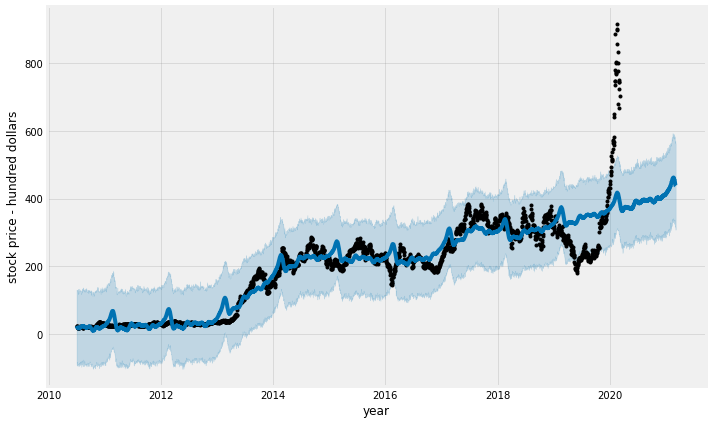

In [142]:
proph_2020.plot(tsla_forecast_2020, uncertainty=True, xlabel='year',ylabel='stock price - hundred dollars')
plt.savefig('../DataSets/Stock_prediction_PNG/Prophet_stock_prediction_2020_2022.png')

[[<matplotlib.lines.Line2D at 0x21dcf928470>],

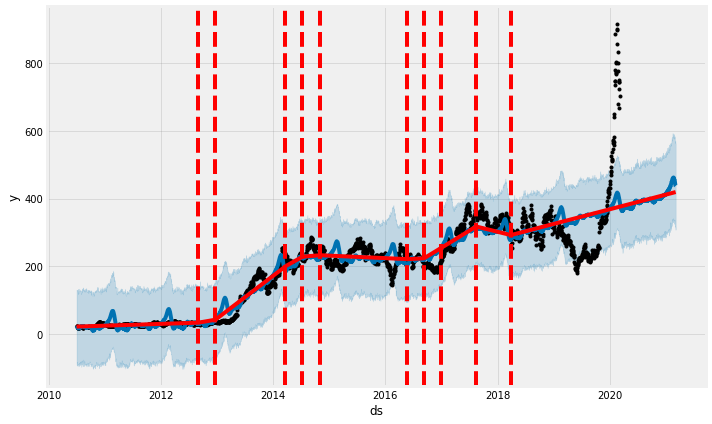

In [143]:
fig_2020 = proph_2020.plot(forecast_2020)
add_changepoints_to_plot(fig_2020.gca(), proph_2020, forecast_2020)

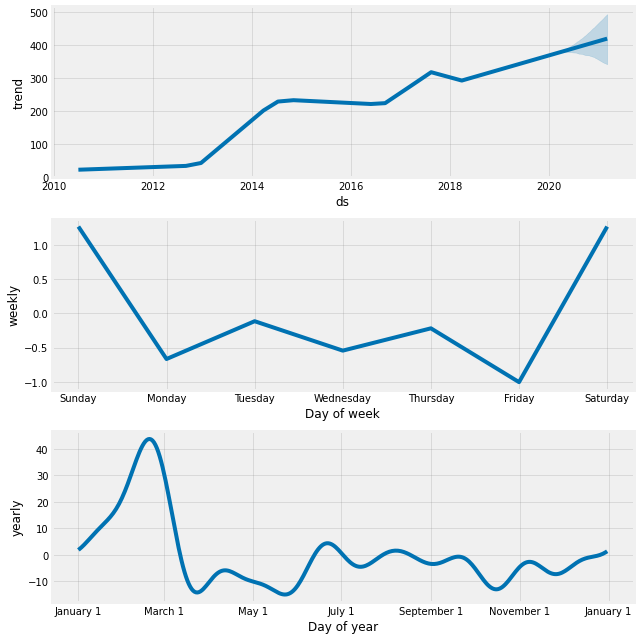

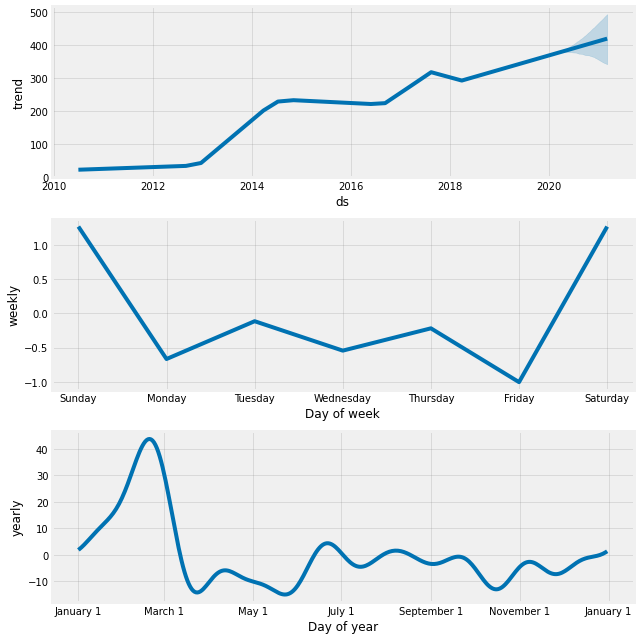

In [144]:
proph_2020.plot_components(forecast_2020)

# Conclusion

- Tesla incredible stock evolution from mid-2019 onwards is quite hard to predict. Overall linear trend from 2010 to 2018 remains the overall long-term trend which has been developed by Prophet

- Prophet tool generates smoothened trends which may seem rather accurate ; the Machine Learning algorithm, fed by 2010-2020 data has generated long-term trend, miscalculating the stock drop in 2019 and the important spike in the stock price in 2020.

- the stock growth trend remains positive for the 2 years predicted, even if, obviously, the further away the prediction is being made, the less accurate it gets, due to high rate of uncertainty (impossible to predict long-term market dynamic, coronavirus crisis etc.)